<a href="https://colab.research.google.com/github/SarangMohaniraj/CreditCardFraudDetection/blob/master/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

This is a binary classification problem from a [Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud). The data contains only numerical, anonymous inputs and is highly unbalanced. It was collected over a 2 day period in September 2013 by European card holders and has 492 frauds out of 284,807 transactions. The positive class (frauds) accounts for 0.172% of all transactions.

There are 3 identifiable features of the dataset: Time of transaction, Amount in the transaction, and the response variable Class, which takes the value 1 in case of fraud and 0 otherwise.

In [1]:
!pip install -q kaggle keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
import kerastuner as kt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading Data 

Finds `kaggle.json`, which contains the username and API key, in the specified Google Drive folder.



In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/"

!kaggle datasets download -d mlg-ulb/creditcardfraud --force

 62% 41.0M/66.0M [00:01<00:00, 26.4MB/s]
100% 66.0M/66.0M [00:01<00:00, 48.8MB/s]


The dataset consists of transformed values to keep them anonymous.

In [4]:
df = pd.read_csv('/content/creditcardfraud.zip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

In this section, we explore the **Class** category, which represents if the transaction is normal or fraudelent. We also look at the **Amount** and **Time** columns.

We confirm that there are 284807 transactions and 31 columns with no missing values.

In [5]:
print(df.shape)
print(df.isnull().values.any())

(284807, 31)
False


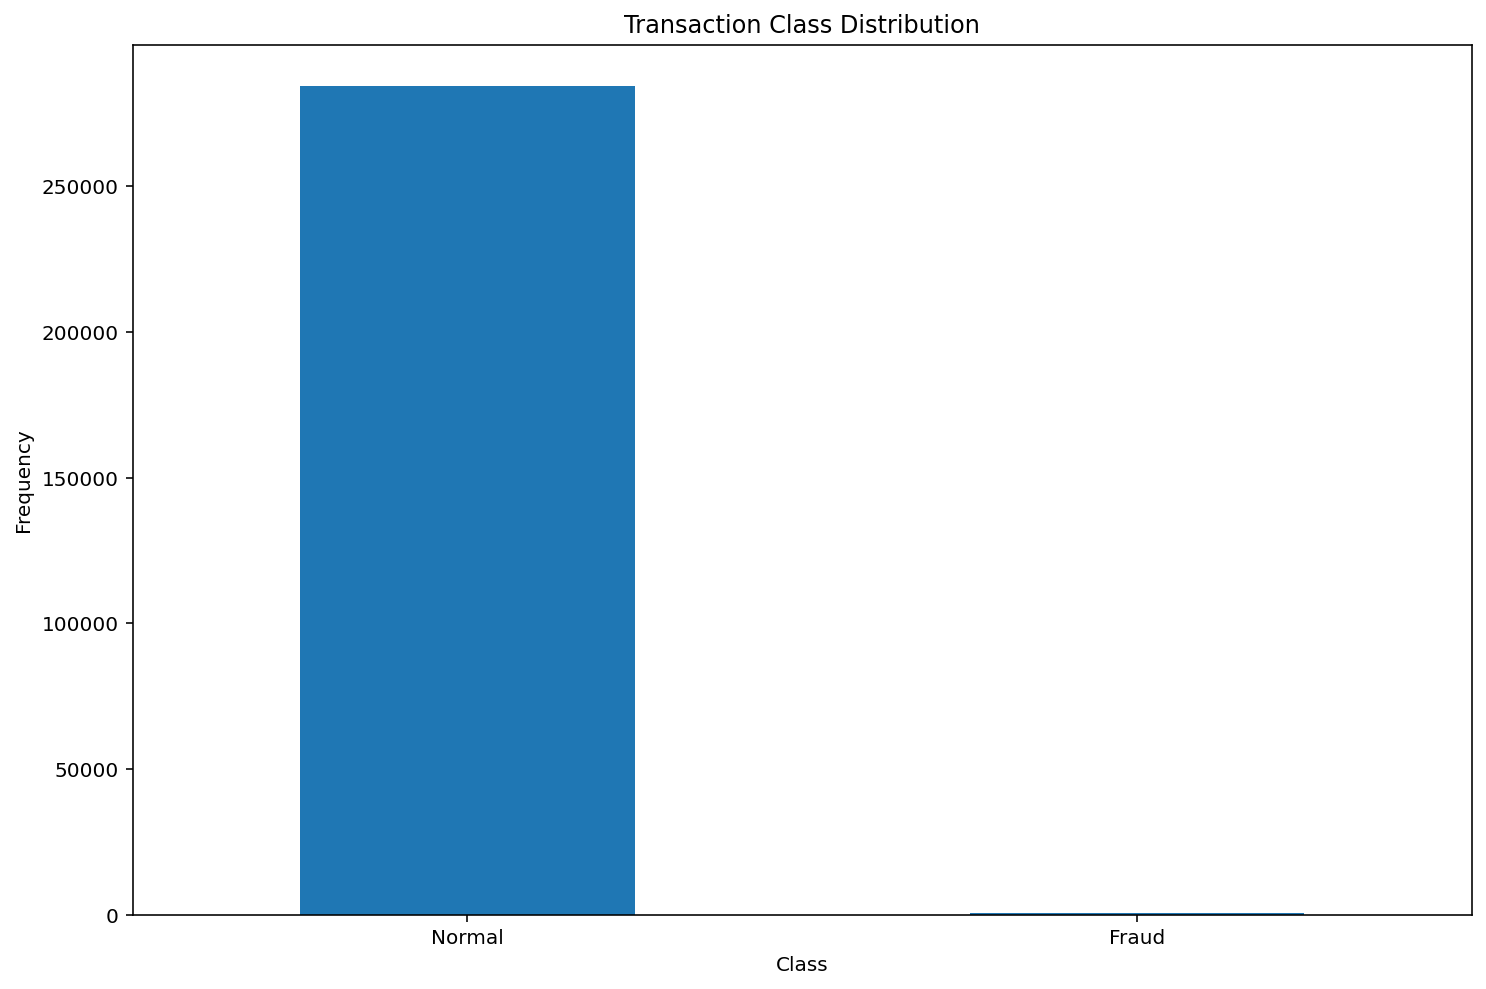

0    284315
1       492


In [6]:
class_count = df['Class'].value_counts()
class_count.plot(kind='bar',figsize=(12,8),title="Transaction Class Distribution",rot=0)
plt.xlabel("Class")
plt.ylabel("Frequency");
plt.xticks(ticks=range(2),labels=["Normal","Fraud"])
plt.show()

print(class_count.to_string())

The data set is clearly unbalanced. We consider the variance in the amount of money in normal and fraudulent transactions. 

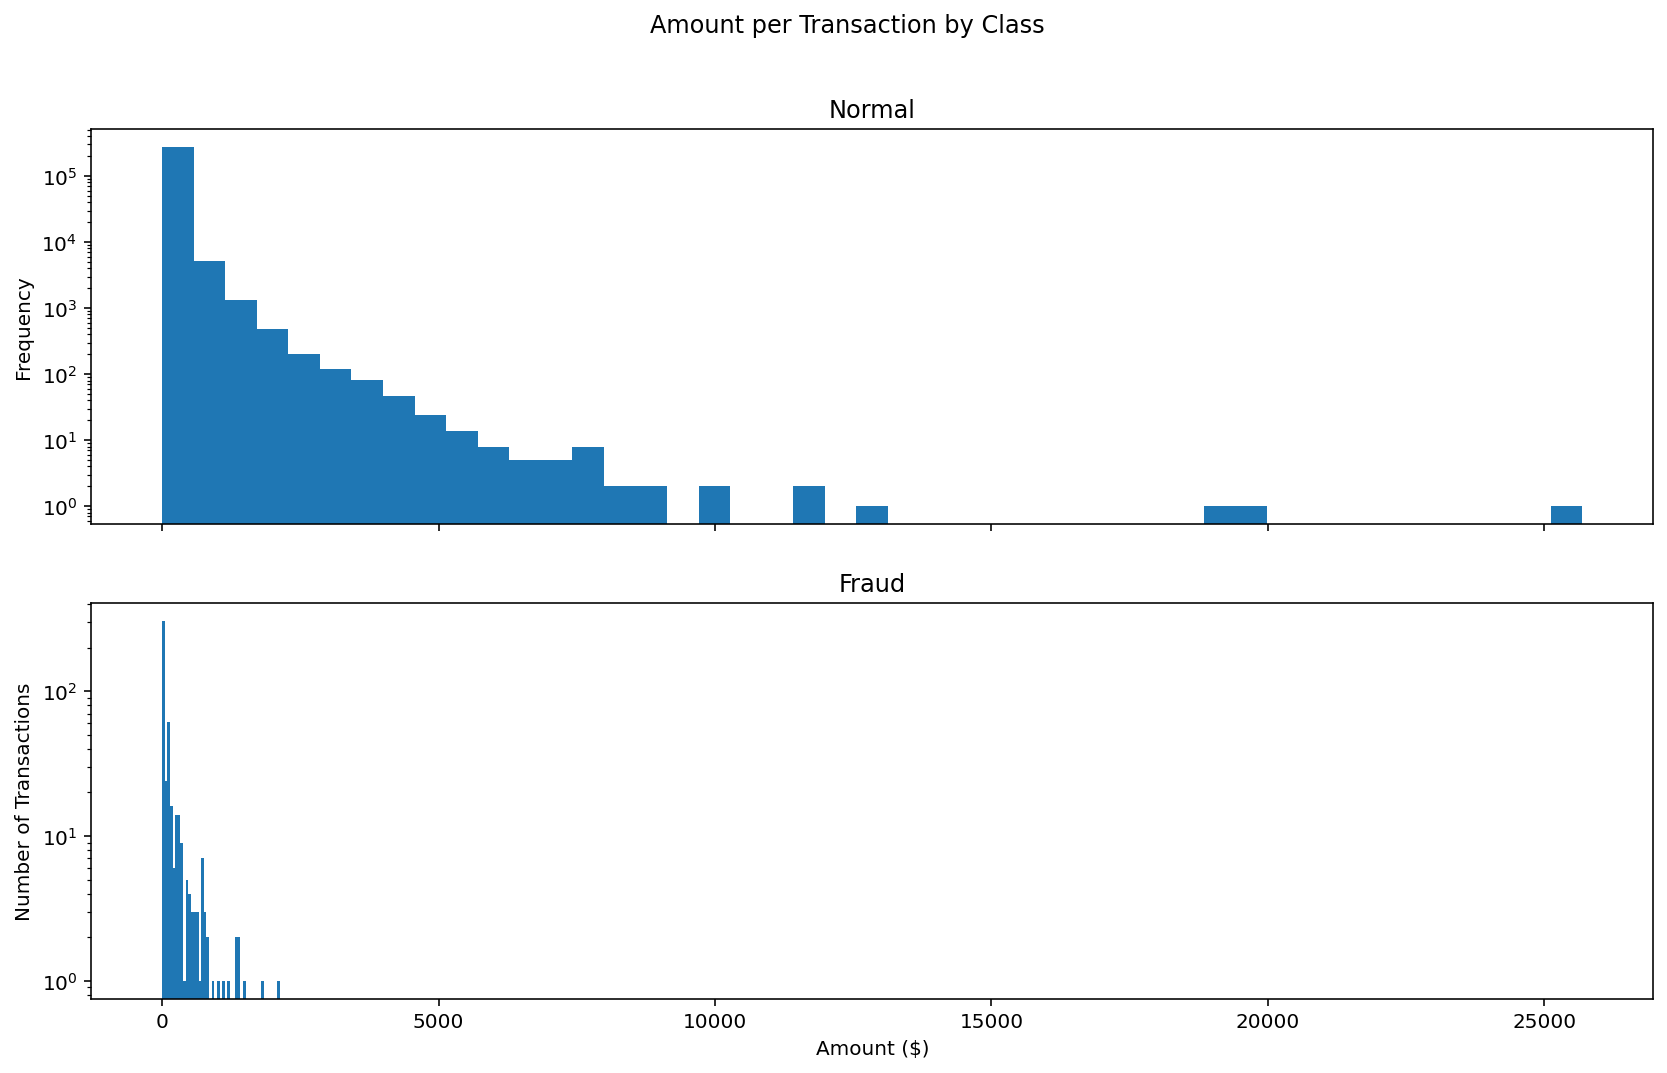

                                         
Normal summary                           Fraud summary
count    284315.000000                   count     492.000000
mean         88.291022                   mean      122.211321
std         250.105092                   std       256.683288
min           0.000000                   min         0.000000
25%           5.650000                   25%         1.000000
50%          22.000000                   50%         9.250000
75%          77.050000                   75%       105.890000
max       25691.160000                   max      2125.870000
skew         17.003147                   skew       3.7544765


In [7]:
normal = df[df['Class']==0]
fraud = df[df['Class']==1]

fig, axs = plt.subplots(nrows=2,figsize=(14,8),sharex=True)
fig.suptitle("Amount per Transaction by Class")
normal['Amount'].plot(kind='hist',ax=axs[0],legend=False,title="Normal",logy=True,bins=45)
fraud['Amount'].plot(kind='hist',ax=axs[1],legend=False,title="Fraud",logy=True,bins=45)
plt.xlabel("Amount ($)")
plt.ylabel("Number of Transactions");
plt.show()

normal_summary = f"""
Normal summary
{normal['Amount'].describe().to_string()}
skew         {round(normal['Amount'].skew(),6)}
"""

fraud_summary = f"""
Fraud summary
{fraud['Amount'].describe().to_string()}
skew       {round(fraud['Amount'].skew(),7)}
"""

for n,f in zip(normal_summary.splitlines(),fraud_summary.splitlines()):
  print(f"{n:40} {f}")

In addition to the **Amount** and **Class** categories, we take a look at the **Time** column. We look and see if time affects the class of the transaction with a scatter plot comparing the amount of the transaction to the time the transaction occured.

According to the scatter plot, time is not a major factor.

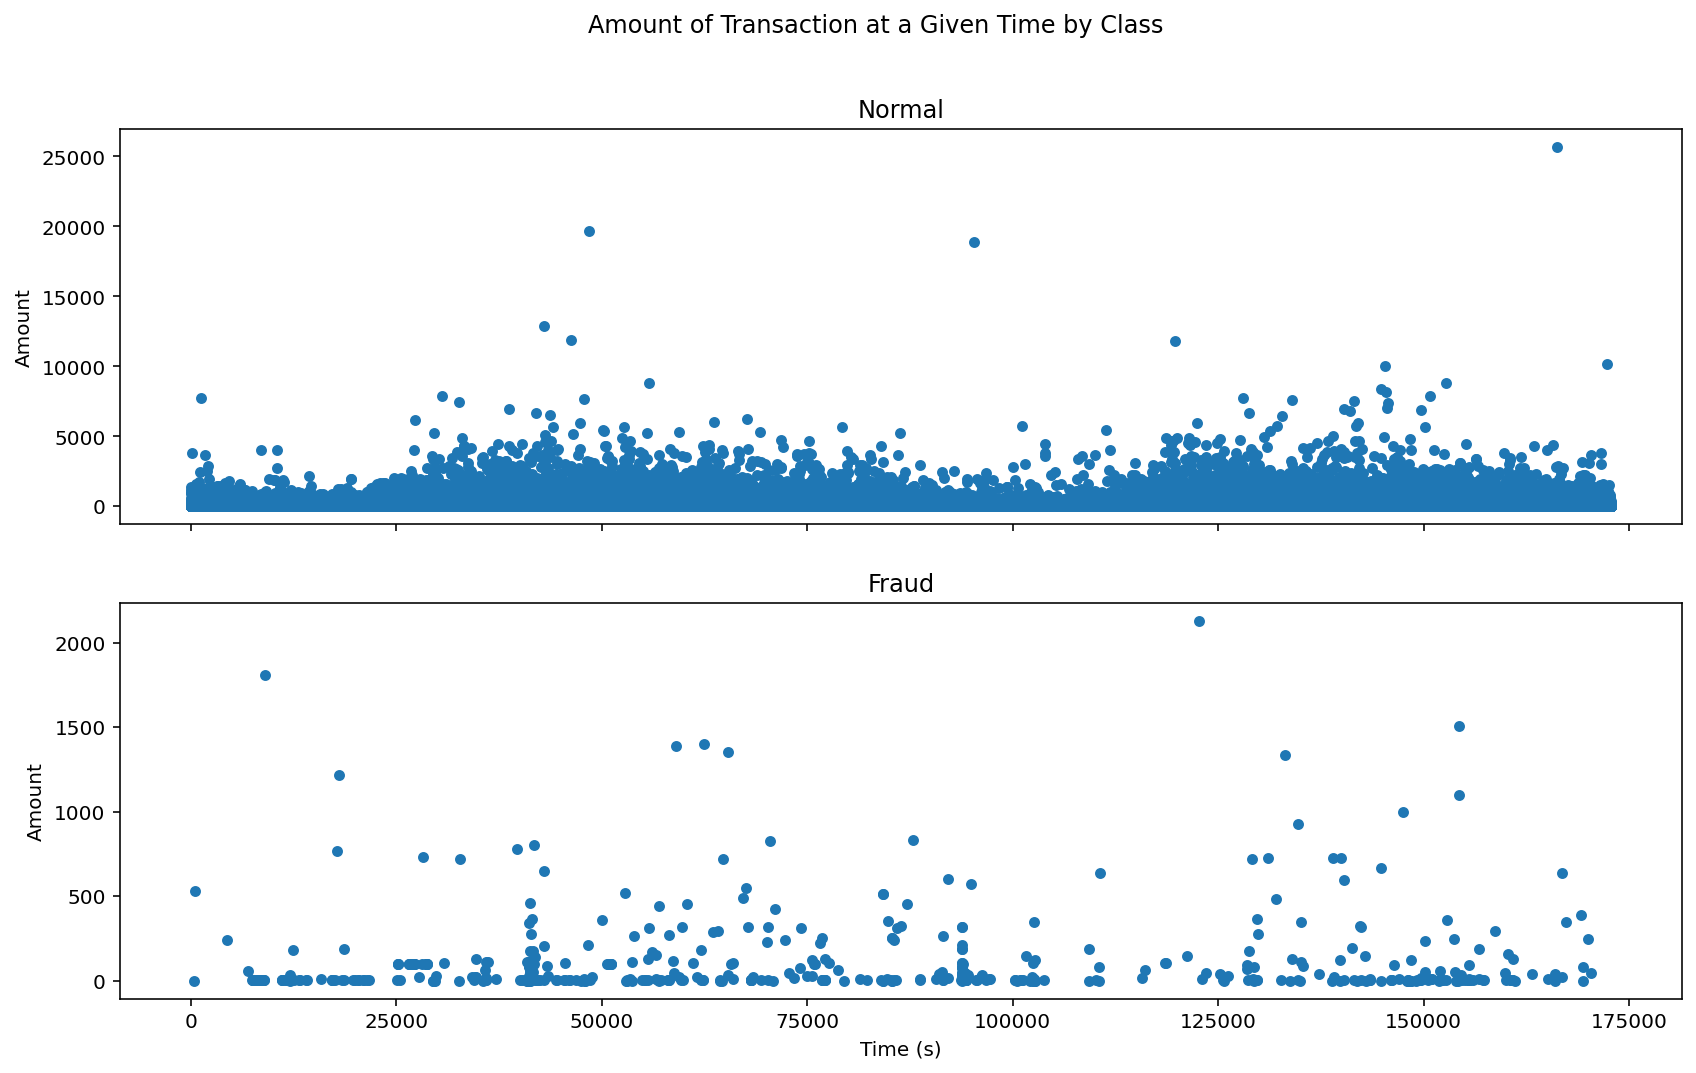

In [8]:
fig, axes = plt.subplots(nrows=2,figsize=(14,8),sharex=True)
fig.suptitle("Amount of Transaction at a Given Time by Class")
normal.plot(kind='scatter',ax=axes[0],x='Time',y='Amount',title="Normal")
fraud.plot(kind='scatter',ax=axes[1],x='Time',y='Amount',title="Fraud")
plt.xlabel("Time (s)")
plt.ylabel("Amount");
plt.show()

Lastly, we look at the correlation between columns in the dataset. Using seaborn, we can create a diagonal correlation matrix. We only need to one triangle because the matrix is symmetric. 

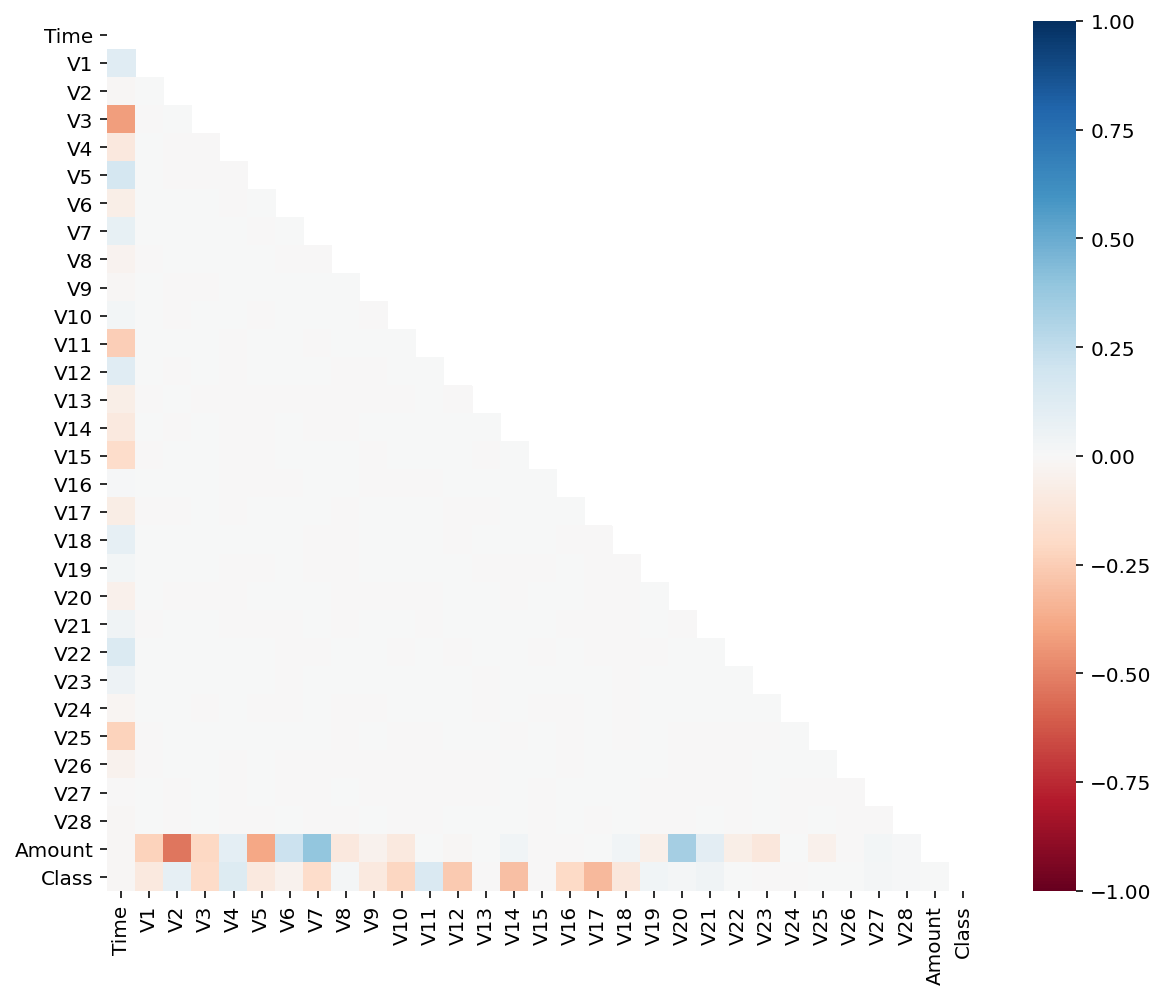

In [9]:
# Compute the correlation matrix
corr = df.corr()

plt.figure(figsize=(10, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr,vmin=-1,vmax=1,mask=mask,square=True,cmap='RdBu',center=0)
plt.show()

## Preprocessing

We have to normalize our data and split the dataset to train and test.

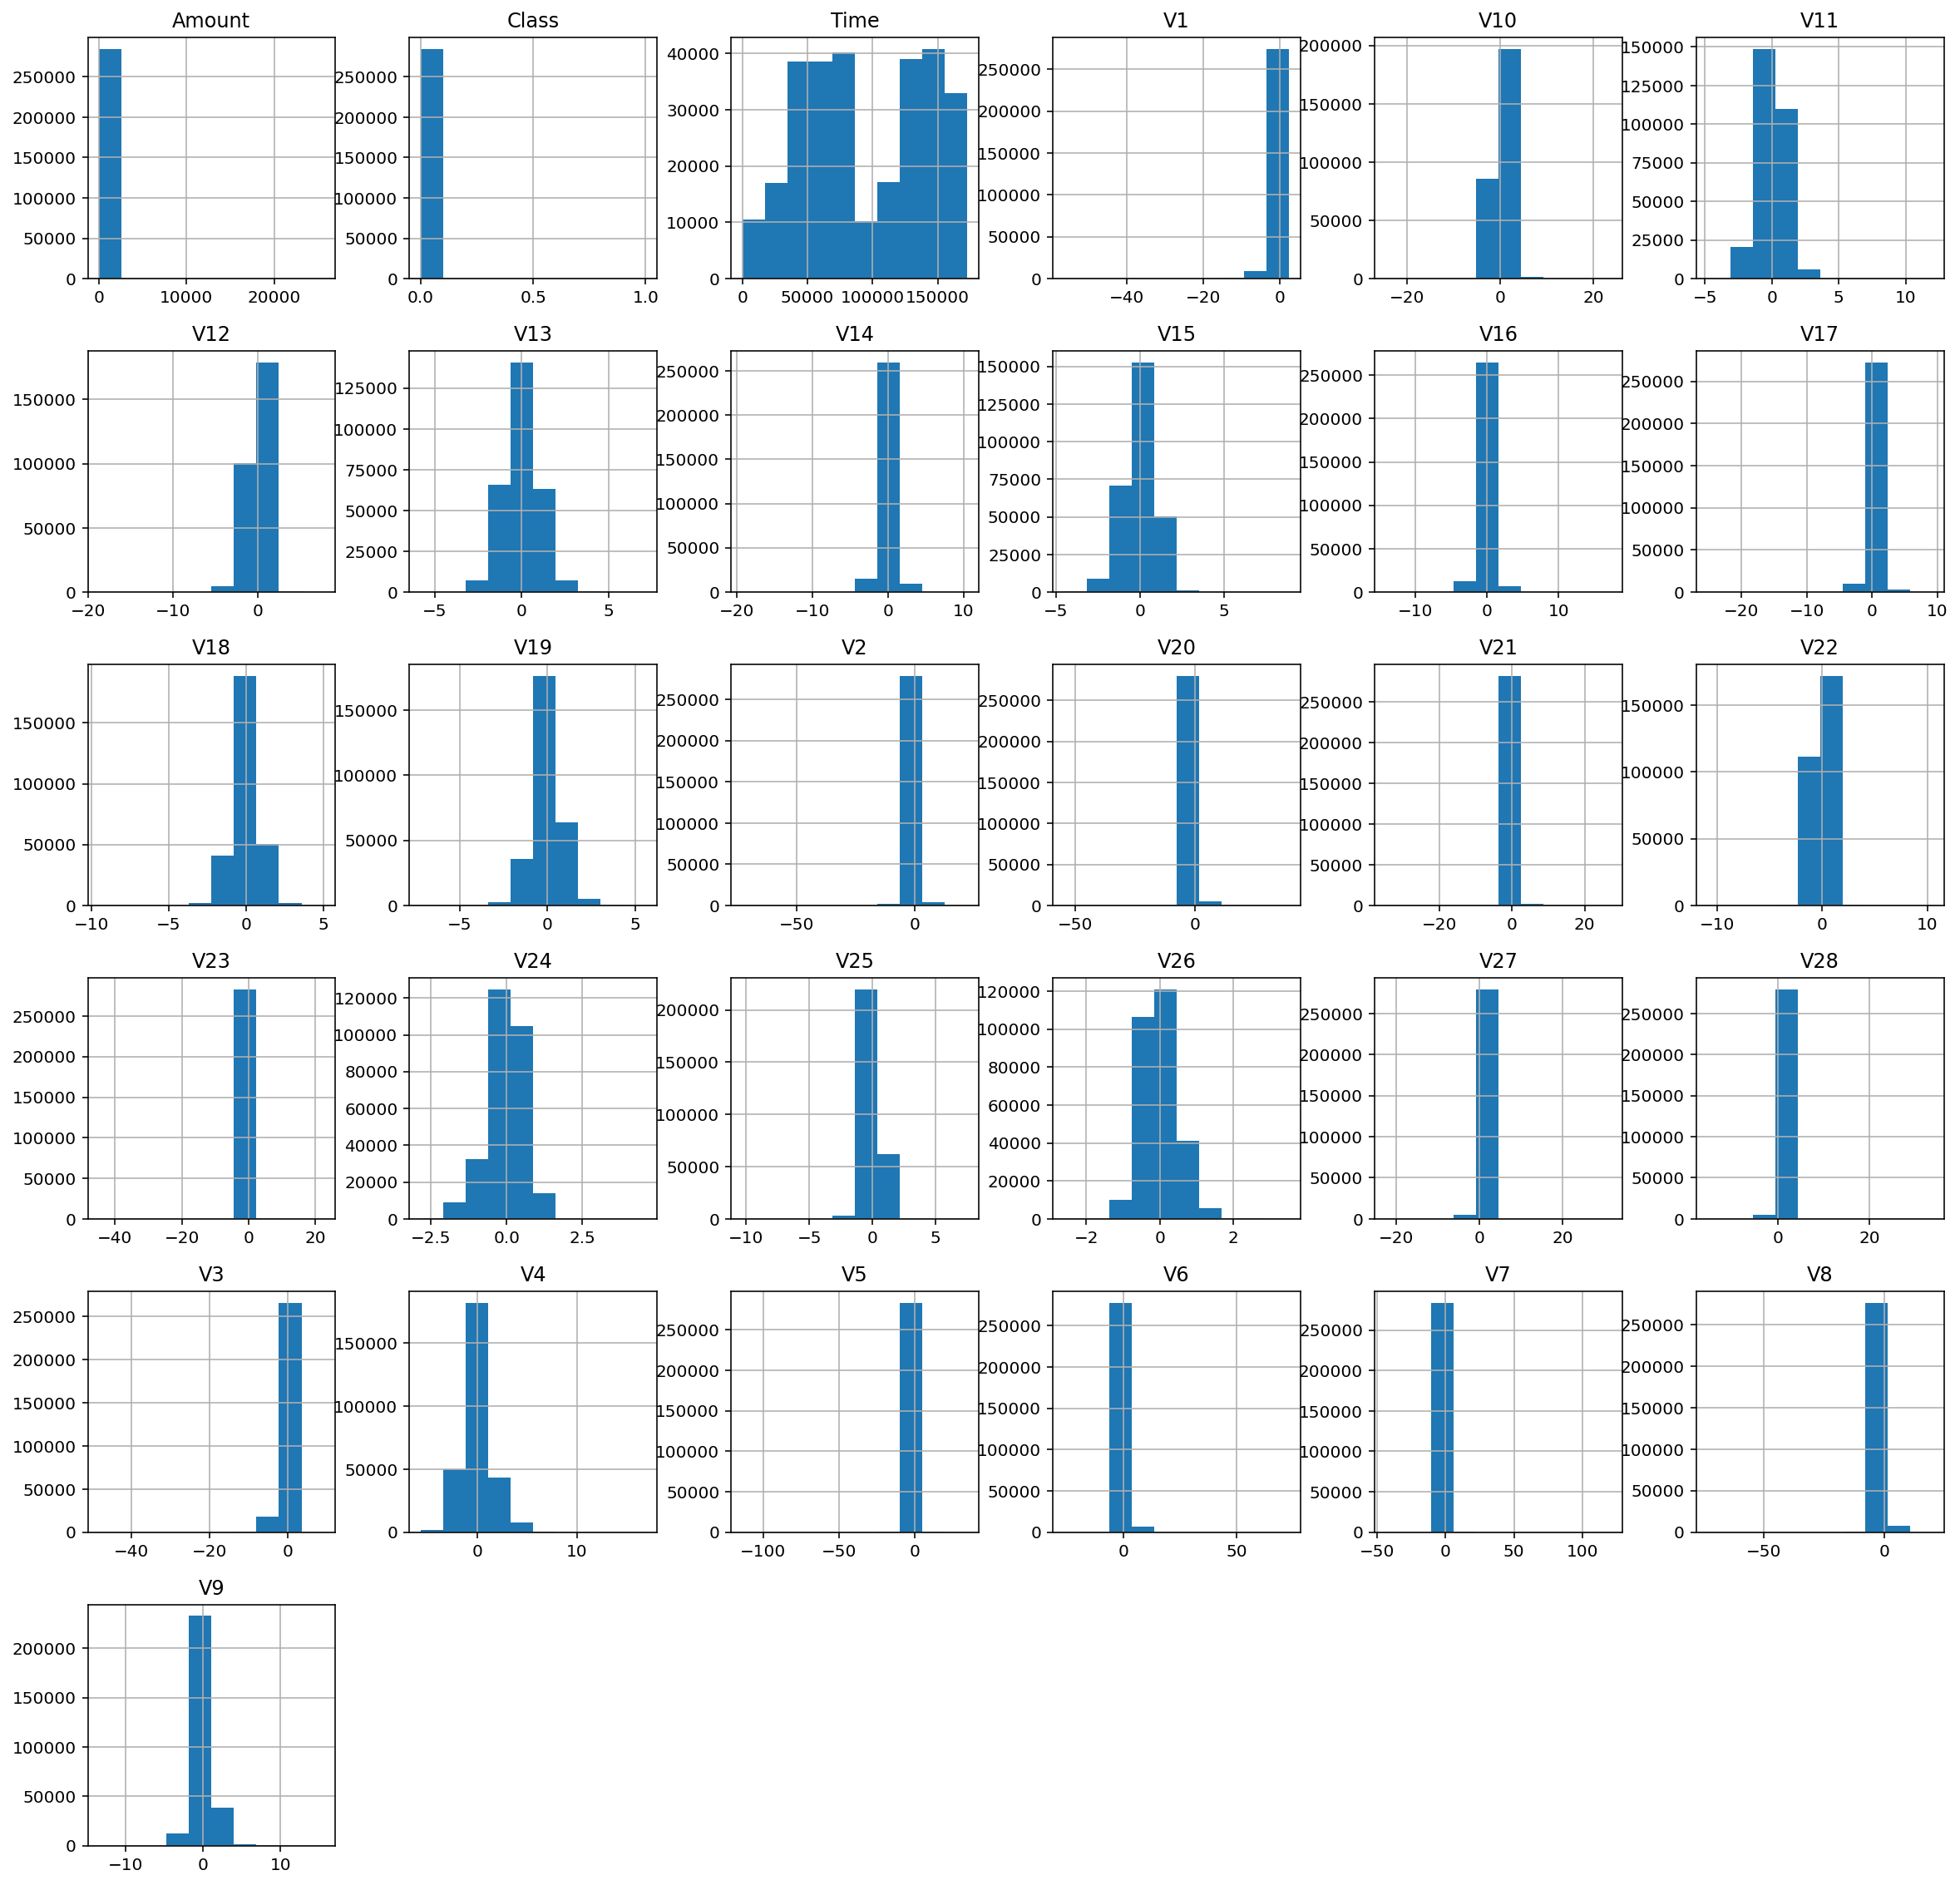

In [10]:
df.hist(figsize=(20,20))
plt.show()

### Standardize Data
$$ z = \frac{x-\bar{x}}{s} $$

In [0]:
# df = (df - df.mean())/df.std(ddof=1)
def standardize(df):
  dataStand = (df - df.mean())/df.std(ddof=1)
  dataStand['Class'] = df['Class'] # Does not standardize Class because it is either 0 or 1
  return dataStand

df = standardize(df)

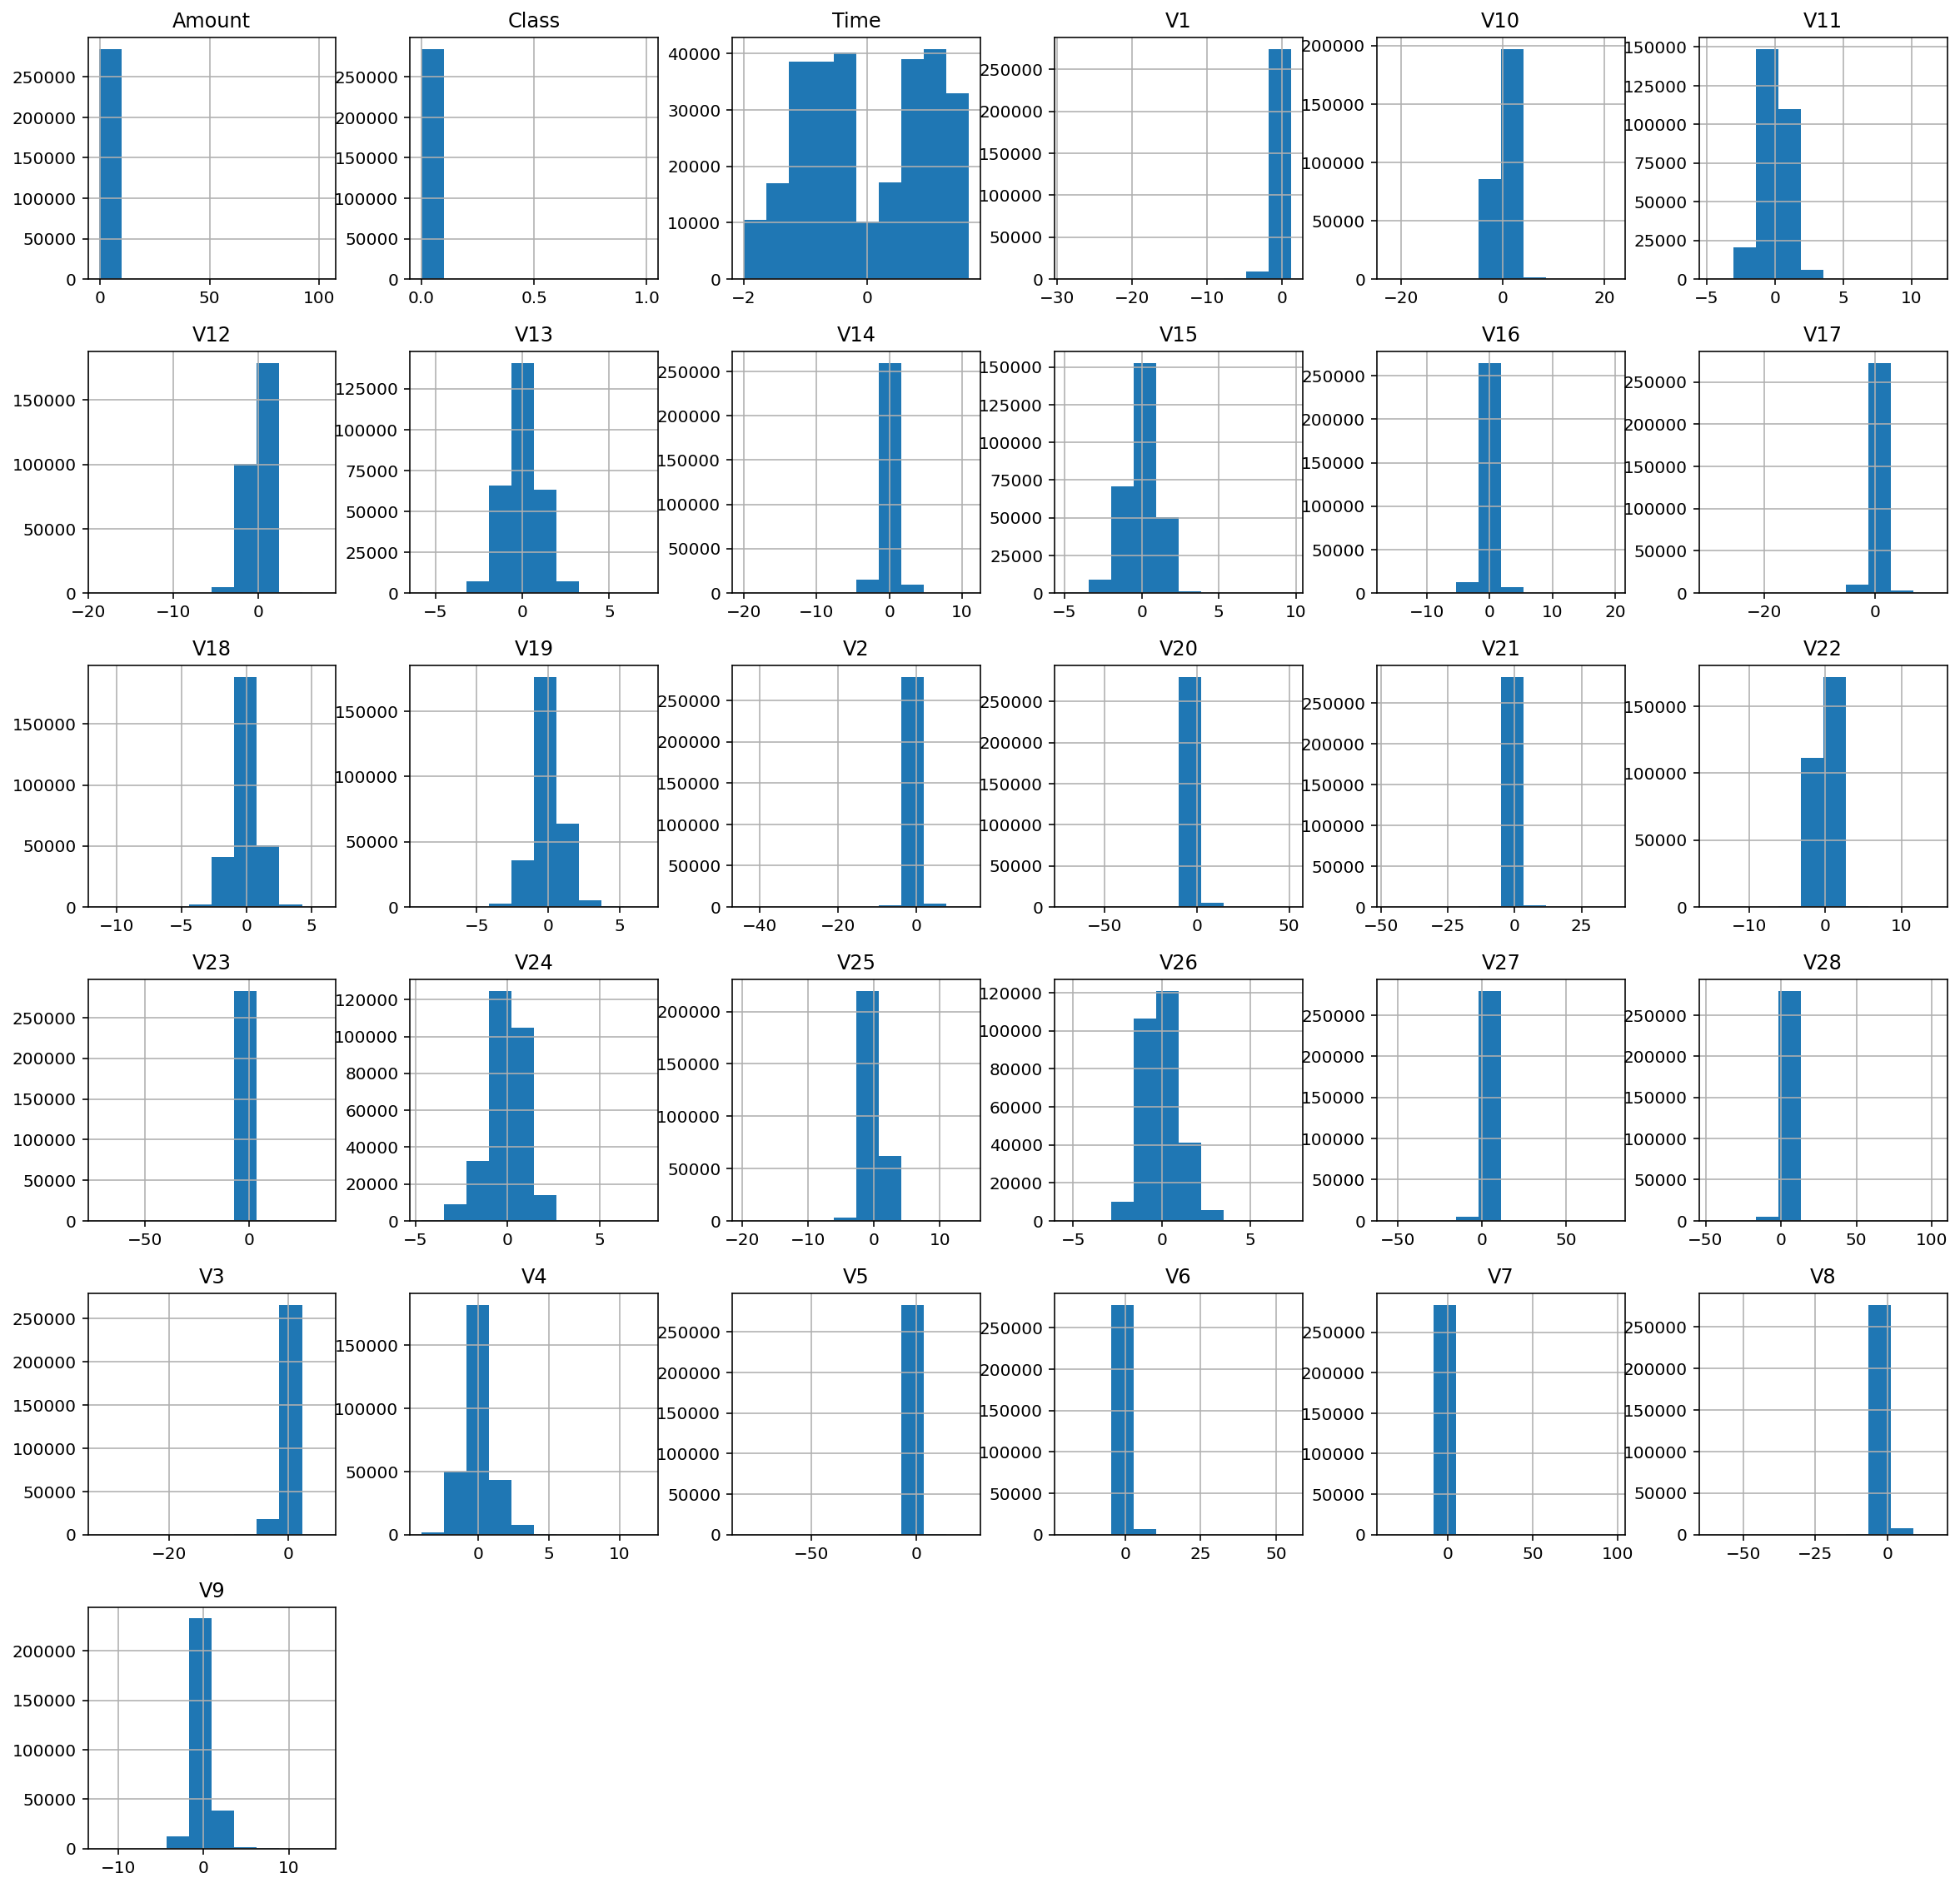

In [12]:
df.hist(figsize=(20,20))
plt.show()

Split dataset into training and testing

In [0]:
train=df.sample(frac=0.9)
test=df.drop(train.index)

X_train = train.drop(['Class'],axis=1)
y_train = train['Class']

X_test = test.drop(['Class'],axis=1)
y_test = test['Class']

## Training

We will use different models and compare the results.

### Measure Predictions on Unbalanced Data

Accuracy does not give reliable information on unbalanced data. For example, even if the model learns to only predict 0, it will still be correct 99% of the time. In binary classification, we can look at the confusion Matrix

<table>
  <caption>Confusion Matrix</caption>
  <tr>
    <th></th>
    <th colspan="3">True Class</th>
  </tr>
  <tr>
    <th colspan="2"></th>
    <th>$\mathbf{+}$</th>
    <th>$\mathbf{-}$</th>
  </tr>
  <th rowspan="3">Predictions</th>
  <tr>
    <th>$\mathbf{+}$</th>
    <td>$\color{green}{\text{True }+}$</td>
    <td>$\color{orange}{\text{False }+}$</td>
  </tr>
  <tr>
    <th>$\mathbf{-}$</th>
    <td>$\color{red}{\text{False }-}$</td>
    <td>$\color{green}{\text{True }-}$</td>
  </tr>
</table>

The columns, **True Class**, are the actual values from the dataset, and the rows, **Predictions**, are the predicted values from the model. In this case, 0 is negative, meaning that the transaction is normal, and 1 is positive, meaning that the transaction is fraudulent.

$\color{green}{\text{True Positive}}$ and $\color{green}{\text{True Negative}}$ means that the model classified the transaction properly (a normal transactions is considered normal and a fraudulent transaction is considered fraudlent). $\color{orange}{\text{False Positive}}$ is also called $\color{orange}{\text{Type I Error }}$ and means that the model believed that a normal transaction was fraudelent. Although the model incorrectly classified the transaction, it is not too harmful in the real world to be too cautious because someone else will take a look at the transaction. On the other hand, $\color{red}{\text{False Negative}}$ is harmful because the model does not identify a fraudulent transaction. This is also called $\color{red}{\text{Type II Error }}$.

#### Key Performance Indicators

1.   Classification Accuracy = 
$\dfrac
  {
    \color{green}{\text{True Positive}} + 
    \color{green}{\text{True Negative}}
  }
  {
    \color{green}{\text{True Positive}} + 
    \color{green}{\text{True Negative}} +
    \color{orange}{\text{False Positive}} +
    \color{red}{\text{False Negative}}
  }
$ \\
$\quad$ This is how accurate the model' predictions are. Even if this is high, especially in an unbalanced dataset, it is not a great metric to base the model on.
2.   Misclassification Rate (Error Rate) = 
$\dfrac
  {
    \color{orange}{\text{False Positive}} +
    \color{red}{\text{False Negative}}
  }
  {
    \color{green}{\text{True Positive}} + 
    \color{green}{\text{True Negative}} +
    \color{orange}{\text{False Positive}} +
    \color{red}{\text{False Negative}}
  }
$ \\
$\quad$ The same goes for the error rate.
3.   Precision = 
$
\dfrac
  {
    \color{green}{\text{True Positive}}
  }
  {
    \text{Total TRUE predictions}
  }
  =
  \dfrac
    {
      \color{green}{\text{True Positive}}
    }
    {
      \color{green}{\text{True Positive}} + 
      \color{orange}{\text{False Positive}}
    }
  \quad
$ \\
"What proportion of positive identifications was actually correct?"
4.   Recall = 
$
\dfrac
  {
    \color{green}{\text{True Positive}}
  }
  {
    \text{Actual Positive}
  }
  =
  \dfrac
    {
      \color{green}{\text{True Positive}}
    }
    {
      \color{green}{\text{True Positive}} + 
      \color{red}{\text{False Negative}}
    }
  \quad
$ \\
"What proportion of actual positives was identified correctly?" \\
Recall is also known as **Sensitivity**, and is called **Power** in statistics.
5.   Area Under Precision-Recall Curve (AUCPR) - Precision and recall have a tradeoff, so with recall on the $x$-axis and precision on the $y$-axis, the curve is concave to the origin. In other words, it decreases at an increasing rate. A perfect classifier may exist if the dataset shows no tradeoff, thus resulting in a horizontal Precision-Recall Curve. The PR curve has a paremter of a threshold which determines the precision and recall at that threshold. The set of thresholds is in $[0,1]$. The PR curve is useful when comparing classifiers. If a curve is greater at every point than another curve, the classifier is better. However, it is more reasonable to see the curves intersecting, which can let you know which classifier to use when favoring either precision or recall. The AUPRC can give a general measure of the curve and is also useful for comparing a classifier to itself. 
6.   F1 Score = 
$
2 \cdot
\dfrac
  {
    \text{precision} \cdot \text{recall}
  }
  {
    \text{precision} + \text{recall}
  }
$ \\
$\quad$ Precision and recall have a tradeoff, so F1 is used when we want a balance between precision and recall. Like AUPRC, it is a general measure.

Precision is a good metric when the cost of $\color{orange}{\text{False Positives}}$ is high. Recall is a good metric when the cost of $\color{red}{\text{False Negatives}}$ is high.





In [0]:
thresholds = np.linspace(0,1,num=100).tolist()

def clean_pr(precision, recall, thresholds=np.linspace(0,1,num=100).tolist()): # there are sometimes (0,0)
  idxs = []
  for idx,(p,r) in enumerate(zip(precision, recall)):
    if p == 0 and r == 0:
      idxs.append(idx)
   
  precision=np.delete(precision,idxs)
  recall=np.delete(recall,idxs)
  thresholds=np.delete(thresholds,idxs).tolist()

  return precision, recall, thresholds

Keras Tuner is used to find the optimal hyperparameters. After trial and error, I determined that the model is better with less layers and units.

In [0]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Add input layer instead of input shape to first layer so we can optimize number of layers

  for i in range(hp.Int('layers', 2, 5)):
    model.add(tf.keras.layers.Dense(
        units=hp.Int(f'units_{i}', min_value=8, max_value=64, step=8),
        activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        )
    )

  model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

  model.compile(
      loss='mse',
      optimizer=tf.keras.optimizers.Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
      ),
      metrics=[
                tf.keras.metrics.Precision(thresholds=thresholds),
                tf.keras.metrics.Recall(thresholds=thresholds),
                tf.keras.metrics.AUC(curve='PR',thresholds=thresholds)
              ]
    )
  return model

The Hyperband tuner is similar to RandomSearch, meaning that it randomly selects hyperparameters, but it is also optimized and uses early stopping.

In [0]:
tuner = kt.Hyperband(build_model,
                     objective = kt.Objective("val_auc", direction="max"),
                     max_epochs = 10,
                     factor = 3,
                     directory="trials",
                     project_name='val_auc'
                    )

In [0]:
# Clear training outputs at the end of each step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    clear_output(wait = True)

In [19]:
tuner.search(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.1, 
    callbacks = [
                 ClearTrainingOutput(),
                 tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.02, patience=0, mode='max')
                ]
  )

INFO:tensorflow:Oracle triggered exit


In [89]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


In [90]:
loss, precision, recall, auprc = model.evaluate(X_test, y_test)
precision, recall, thresholds = clean_pr(precision, recall)
y_pred = model.predict(X_test)

891/891 [==============================] - 3s 3ms/step - loss: 7.0053e-04 - precision: 0.8062 - recall: 0.6740 - auc: 0.8267


### Precision-Recall Curve

We first take a look at how the threshold affects the precision and recall individually, and then eliminate the parameter to get the Precision-Recall Curve.

In [0]:
def pr_threshold_curve(precision, recall, thresholds):
  fig, ax = plt.subplots(figsize=(10,4))
  ax2=ax.secondary_yaxis(location='right')
  ax.plot(thresholds,precision,label="Precision",c='tab:blue')
  ax.plot(thresholds,recall,label="Recall",c='tab:orange')
  plt.title("Precision and Recall per Threshold")
  plt.xlabel("Threshold")
  ax.set_ylabel("Precision",c='tab:blue')
  ax2.set_ylabel("Recall",c='tab:orange')
  plt.legend()
  plt.show()

def pr_curve(precision, recall):
  plt.figure(figsize=(10,4))
  plt.plot(recall,precision)
  plt.title("Precision-Recall Curve")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.show()

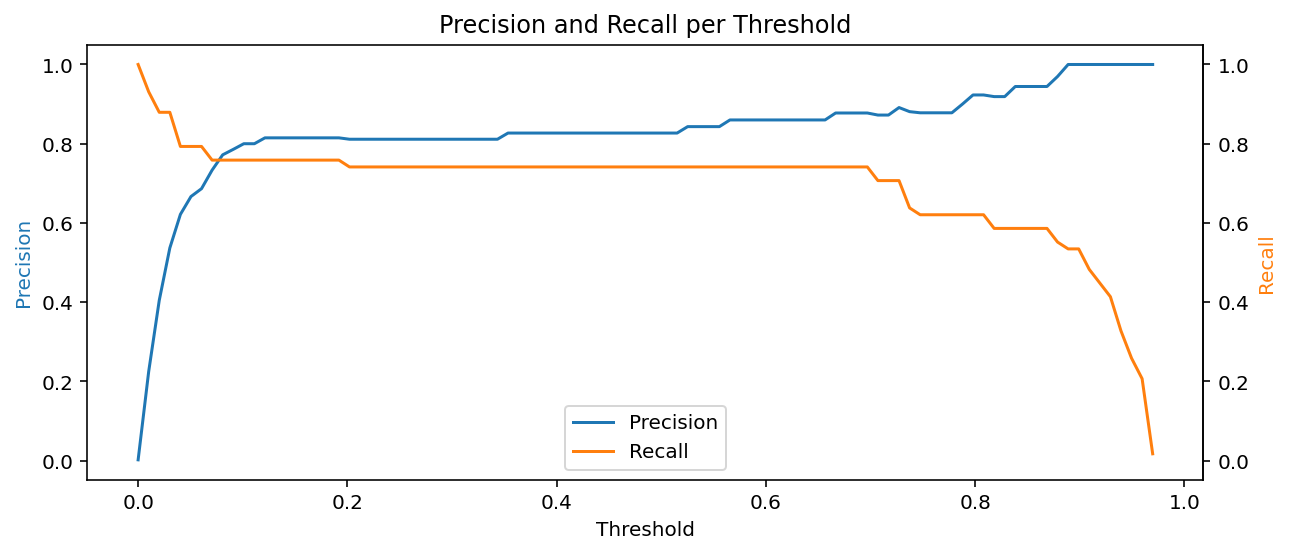

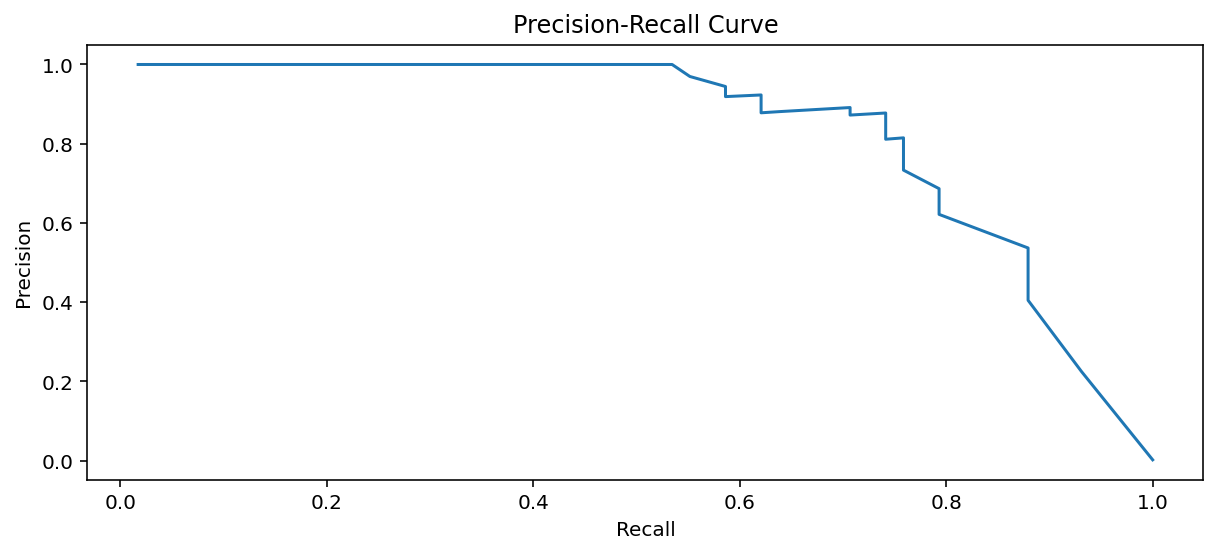

In [92]:
pr_threshold_curve(precision, recall, thresholds)
pr_curve(precision, recall)

#### Confusion Matrix from Threshold

We pick a threshold from the previous graphs. Since we want to reduce the number of identified fraudulent transactions, we want a higher recall, which is at a lower threshold. However, if we have a lower threshold, the model is more likely to think that a normal transaction is a fraudulent transaction, which creates more false positives. Regardless, the sacrifice of increased false positives for reduced false negatives is preferable when detecting credit card fraud. This is another demonstration of the Precision-Recall Curve tradeoff.

In [0]:
def confusion_matrix(y_pred,y_test,threshold):
  y_pred_threshold = (y_pred.flatten() > threshold).astype(int)
  confusion_matrix = pd.crosstab(y_pred_threshold,y_test)

  plt.figure(figsize=(4, 4))
  ax = sns.heatmap(confusion_matrix,annot=True,fmt='d',cbar=False,cmap='twilight',square=True,linewidths=1,annot_kws={"size": 18},xticklabels=['Normal','Fraud'],yticklabels=['Normal','Fraud'])
  plt.title("Confusion Matrix", fontsize=24)
  plt.xlabel('Predicted Class', fontsize=16)
  plt.ylabel('True Class', fontsize=16)
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  ax.invert_xaxis()
  ax.invert_yaxis()
  ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
  ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
  plt.show()

def f1(p,r):
  return 2 * p * r / (p + r)

def pr_summary(precision, recall, thresholds, threshold):
  idx = (np.abs(np.array(thresholds)-threshold)).argmin()
  f1_score = f1(precision[idx],recall[idx])
  print(f"""
  Area Under Precision-Recall Curve: \t{auprc:.3f}
  Threshold: \t{thresholds[idx]:.3f}
    Precision: \t{precision[idx]:.3f}
    Recall: \t{recall[idx]:.3f}
    F1 Score: \t{f1_score:.3f}
  """)

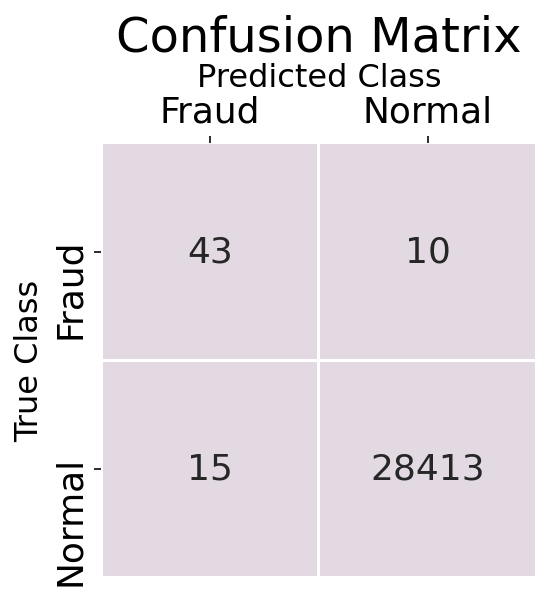


  Area Under Precision-Recall Curve: 	0.827
  Threshold: 	0.202
    Precision: 	0.811
    Recall: 	0.741
    F1 Score: 	0.775
  


In [96]:
threshold = 0.2
confusion_matrix(y_pred, y_test, threshold)
pr_summary(precision, recall, thresholds, threshold)

#### Model Building without Keras Tuner

In [97]:
thresholds = np.linspace(0,1,num=100).tolist()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=48,input_dim=X_train.shape[1],activation='tanh'))
model.add(tf.keras.layers.Dense(units=64,activation='relu'))
model.add(tf.keras.layers.Dense(units=32,activation='tanh'))
model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.Precision(thresholds=thresholds),tf.keras.metrics.Recall(thresholds=thresholds),tf.keras.metrics.AUC(curve='PR',thresholds=thresholds)]
  )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 48)                1488      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3136      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 6,737
Trainable params: 6,737
Non-trainable params: 0
_________________________________________________________________


In [98]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
7210/7210 [==============================] - 32s 4ms/step - loss: 9.7870e-04 - precision_1: 0.5786 - recall_1: 0.6473 - auc_1: 0.6478 - val_loss: 6.4172e-04 - val_precision_1: 0.7207 - val_recall_1: 0.7442 - val_auc_1: 0.7439
Epoch 2/10
7210/7210 [==============================] - 32s 4ms/step - loss: 5.8118e-04 - precision_1: 0.8032 - recall_1: 0.6639 - auc_1: 0.7412 - val_loss: 6.2602e-04 - val_precision_1: 0.7430 - val_recall_1: 0.7353 - val_auc_1: 0.7998
Epoch 3/10
7210/7210 [==============================] - 31s 4ms/step - loss: 5.0625e-04 - precision_1: 0.8218 - recall_1: 0.7048 - auc_1: 0.7877 - val_loss: 5.8128e-04 - val_precision_1: 0.7623 - val_recall_1: 0.6986 - val_auc_1: 0.7526
Epoch 4/10
7210/7210 [==============================] - 31s 4ms/step - loss: 5.2381e-04 - precision_1: 0.8068 - recall_1: 0.7003 - auc_1: 0.7654 - val_loss: 6.2526e-04 - val_precision_1: 0.7235 - val_recall_1: 0.7649 - val_auc_1: 0.7315
Epoch 5/10
7210/7210 [==============================

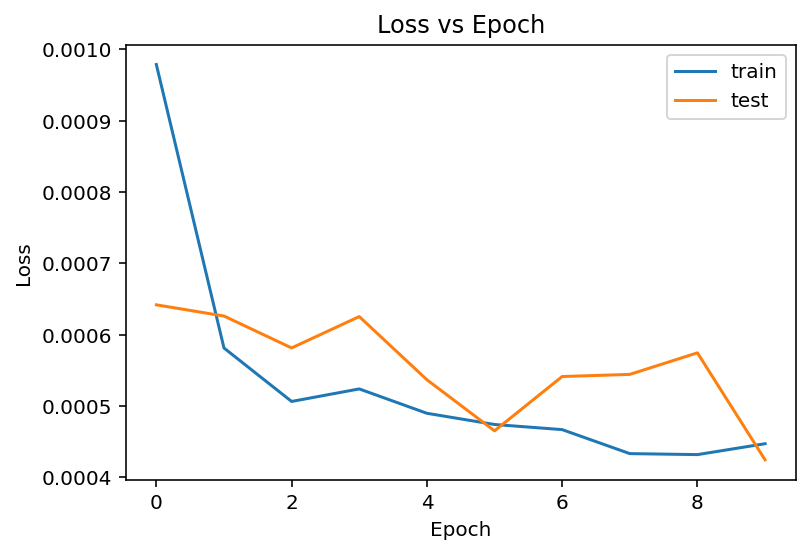

In [99]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend();
plt.show()

In [101]:
loss, precision, recall, auprc = model.evaluate(X_test, y_test)
precision, recall, thresholds = clean_pr(precision, recall)
y_pred = model.predict(X_test)

891/891 [==============================] - 3s 3ms/step - loss: 6.7659e-04 - precision_1: 0.8256 - recall_1: 0.6584 - auc_1: 0.7643


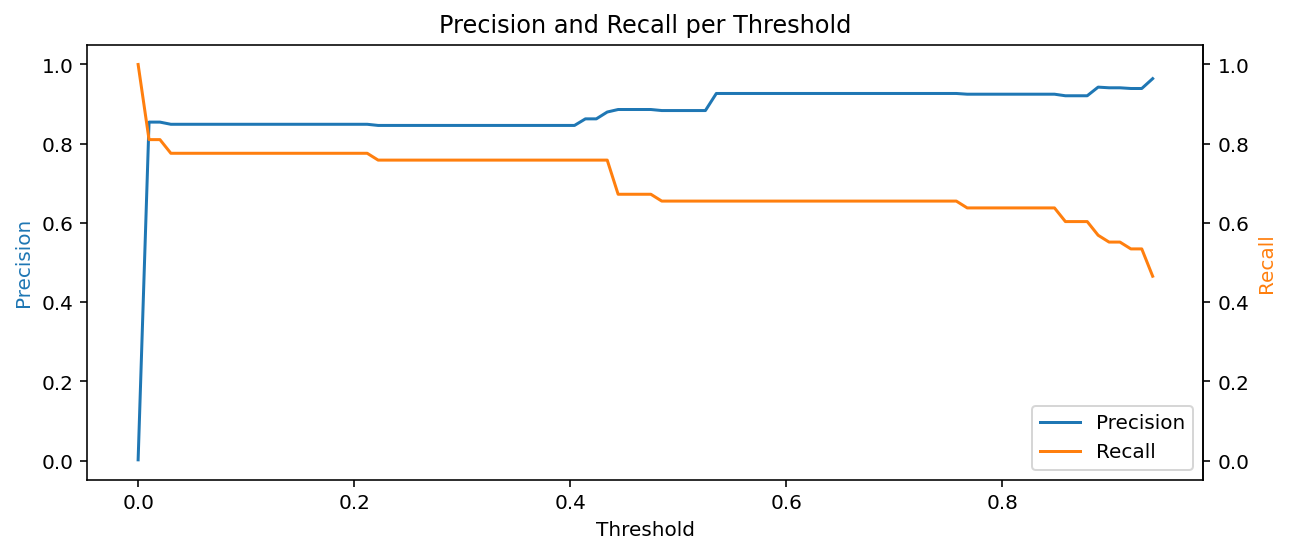

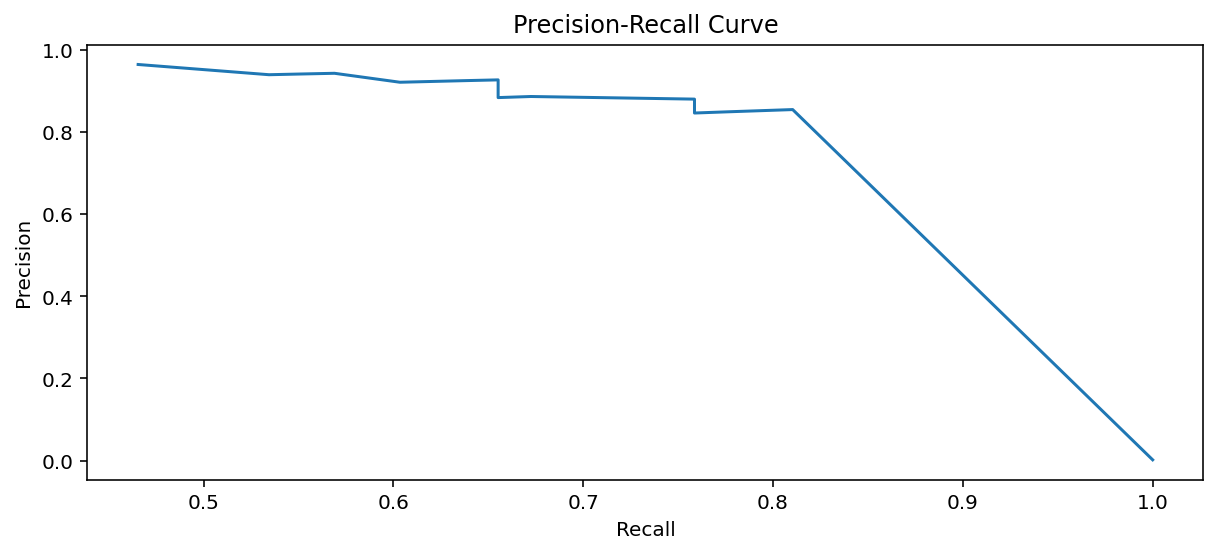

In [102]:
pr_threshold_curve(precision, recall, thresholds)
pr_curve(precision, recall)

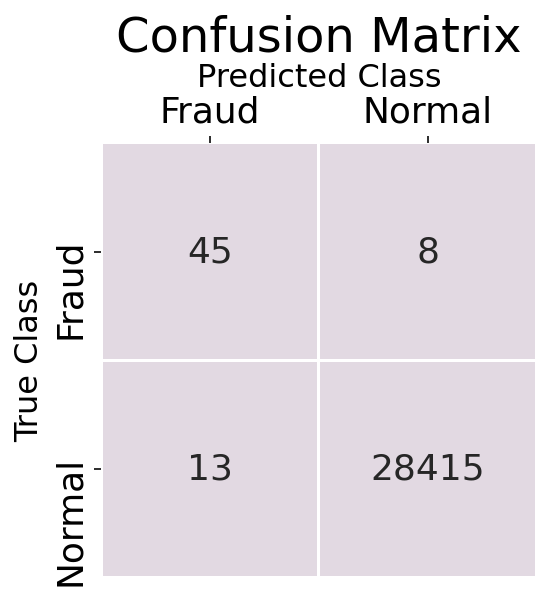


  Area Under Precision-Recall Curve: 	0.764
  Threshold: 	0.202
    Precision: 	0.849
    Recall: 	0.776
    F1 Score: 	0.811
  


In [103]:
threshold = 0.2
confusion_matrix(y_pred, y_test, threshold)
pr_summary(precision, recall, thresholds, threshold)